# High Resol 구현
## 목적
: source 개수를 변인으로 두고, checkboard 모델이 복구되는 정도를 검증한다
## 실험 방법
: Source 개수를 다르게한
CFWI, MFWI, EFWI 수행
epoch은 모두 5000으로 동일

In [1]:
import torch
import deepwave
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

from Tools.processing import normalized_shot_gather
from Tools.soft_dtw_cuda import SoftDTW
from Tools.plot import csg
from Tools.processing import low_cut

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import scipy
import random
from tqdm import tqdm
import torch.nn as nn

In [2]:
def create_checkerboard_model_robust(
    nx, nz, dx, dz,
    vs_initial, perturbation,
    checker_region_m, checker_size_m
):
    """
    격자 간격을 고려하여 체커보드 형태의 Vs 속도 모델을 생성합니다. (Robust version)

    Args:
        nx (int): x 방향 전체 격자점의 수.
        nz (int): z 방향 전체 격자점의 수.
        dx (float): x 방향 격자 간격 (m).
        dz (float): z 방향 격자 간격 (m).
        vs_initial (float): 배경 S파 속도 (m/s).
        perturbation (float): 속도 변화율 (예: 0.1은 10%).
        checker_region_m (tuple): (start_x_m, end_x_m, start_z_m, end_z_m) 미터 단위 체커보드 영역.
        checker_size_m (tuple): (size_x_m, size_z_m) 미터 단위 체커 하나의 크기.

    Returns:
        torch.Tensor: 최종 Vs 속도 모델.
    """
    # 1. 배경 속도 모델 생성
    vs_model = torch.full((nz, nx), vs_initial, dtype=torch.float32)

    # 2. 미터 단위를 격자 인덱스로 변환
    start_x = int(checker_region_m[0] / dx)
    end_x = int(checker_region_m[1] / dx)
    start_z = int(checker_region_m[2] / dz)
    end_z = int(checker_region_m[3] / dz)

    # 3. 체커 하나의 크기를 격자점 수로 변환
    checker_nx = int(checker_size_m[0] / dx)
    checker_nz = int(checker_size_m[1] / dz)

    # 4. 체커보드 영역의 인덱스 그리드 생성
    z_indices = torch.arange(start_z, end_z).unsqueeze(1)
    x_indices = torch.arange(start_x, end_x).unsqueeze(0)

    # 5. 격자 간격을 고려한 체커보드 패턴 생성
    # floor division을 통해 각 격자점이 몇 번째 체커에 속하는지 계산
    z_pattern = torch.floor(z_indices / checker_nz)
    x_pattern = torch.floor(x_indices / checker_nx)
    
    # 좌상단이 음의 섭동이 되도록 패턴 생성 (-1과 1)
    pattern = (z_pattern + x_pattern) % 2
    final_pattern = -((pattern * 2) - 1)

    # 6. 속도 변화량 계산 및 적용
    vs_delta = vs_initial * perturbation
    vs_model[start_z:end_z, start_x:end_x] += final_pattern * vs_delta

    return vs_model

In [3]:
class EnvelopeLoss(nn.Module):
    """
    관측 파형과 모델링 파형의 Envelope 차이를 계산하는 PyTorch Loss 클래스입니다.
    E(t) = (u(t)^2 + H[u(t)]^2)^(p/2)
    Loss = MSE(E_obs, E_syn)
    """
    def __init__(self, p: float = 1.0):
        """
        Args:
            p (float): Envelope 계산 시 적용할 지수 (기본값: 1.0)
        """
        super().__init__()
        if p <= 0:
            raise ValueError("지수 'p'는 양수여야 합니다.")
        self.p = p
        self.mse_loss = nn.MSELoss()

    def _calculate_envelope(self, signal: torch.Tensor) -> torch.Tensor:
        """Helper-function to compute the envelope of a signal tensor."""
        if signal.dim() != 3:
            raise ValueError("입력 신호는 3차원 텐서(n_shot, n_rec, n_t)여야 합니다.")

        n = signal.size(-1)
        # Hilbert transform via FFT
        fft = torch.fft.fft(signal, n=n, dim=-1)

        h = torch.zeros(n, device=signal.device, dtype=signal.dtype)
        h[0] = 1
        # Create frequency-domain filter for Hilbert transform
        if n % 2 == 0:
            h[1:n // 2] = 2
            h[n // 2] = 1
        else:
            h[1:(n + 1) // 2] = 2
        
        fft = fft * h.view(1, 1, -1) # Apply filter via broadcasting
        analytic_signal = torch.fft.ifft(fft, n=n, dim=-1)

        # Envelope is the magnitude of the analytic signal
        envelope = torch.sqrt(signal**2 + analytic_signal.imag**2)
        
        return envelope**self.p

    def forward(self, syn: torch.Tensor, obs: torch.Tensor) -> torch.Tensor:
        """
        모델링 파형(syn)과 관측 파형(obs)의 envelope loss를 계산합니다.
        """
        env_syn = self._calculate_envelope(syn)
        env_obs = self._calculate_envelope(obs)
        
        return self.mse_loss(env_syn, env_obs)

In [4]:
offset = 3 #m
src_spacing = 6 #m
n_gp = 24
gp_spacing = 1 #m

geophone = np.arange(0, gp_spacing * n_gp, gp_spacing)
x_m = 40
z_m = 10
dx = 0.2

nx = int(x_m/dx)
nz = int(z_m / dx)

In [5]:
shots = torch.arange(5, 5+src_spacing*6, src_spacing).to(device=device) / dx

In [6]:
receiver = torch.arange(8, 32, gp_spacing).to(device=device) / dx

In [7]:
vs_back = 200
vp_back = 500
rho_back = 2000

In [8]:
fs = 1000
dt = 1/fs
t= 0.5
nt = int(t/dt)
time = np.arange(0, dt * nt, dt)

In [9]:
region_orig = (10.0, 31.0, 2.0, 8.0) # 미터 단위
checker_orig = (1.0, 1.0)   

In [10]:
original_model = create_checkerboard_model_robust(
    nx=nx, nz=nz, dx=dx, dz=dx,
    vs_initial=200.0, perturbation=0.10,
    checker_region_m=region_orig, checker_size_m=checker_orig
)

In [11]:
original_model = original_model.to(device)

In [12]:
V_MAX = 220
V_MIN = 180
data_range = V_MAX - V_MIN

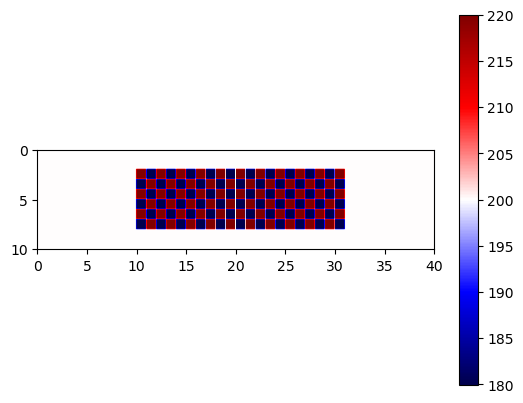

In [13]:
plt.figure()
plt.imshow(original_model.detach().cpu().numpy(), cmap='seismic', aspect = 'equal', extent=[0, nx*dx, nz*dx, 0], vmax = V_MAX, vmin = V_MIN)
plt.colorbar()
plt.show()

In [14]:
vp_f, vs_inv, rho_f = torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device), torch.zeros((nz, nx), device=device)
vp_f[:, :] = vp_back
vs_inv[:, :] = vs_back
rho_f[:, :] = rho_back

In [15]:
ssim_score = structural_similarity(
    original_model.detach().cpu().numpy(),
    vs_inv.detach().cpu().numpy(),
    win_size = 5,
    data_range = data_range,
)
print(f"모델 복원 유사도 (SSIM 점수): {ssim_score:.4f}")

모델 복원 유사도 (SSIM 점수): 0.6054


In [16]:
n_shots = len(shots)
n_sources_per_shot = 1

f0 = 40
peak_time = 1.5/f0

source_amplitudes = (
    (deepwave.wavelets.ricker(f0, nt, dt, peak_time))
    .repeat(n_shots, n_sources_per_shot, 1).to(device)
)

shot = torch.zeros(n_shots, n_sources_per_shot, 2, dtype=torch.long, device=device)
shot[..., 0] = 2
shot[..., 1] = (shots).unsqueeze(1)

In [17]:
receiver_locations = torch.zeros(n_shots, len(receiver), 2, dtype=torch.long, device=device)
receiver_locations[..., 0] = 0
receiver_locations[:, :, 1] = receiver

In [18]:
obs = deepwave.elastic(
    *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, original_model, rho_f),
    grid_spacing=dx, dt=dt,
    source_amplitudes_y=source_amplitudes,
    source_locations_y=shot,
    receiver_locations_y=receiver_locations,
    pml_freq=f0, pml_width=[0, 10, 10, 10]
)[-2]
obs = normalized_shot_gather(obs)

In [19]:
n_epoch = 1000
lr = 1e-2

loss_fn = torch.nn.MSELoss()
losses_c = []
losses_c_shot = []
vs_c_list = []

In [20]:
# 6개의 shot에 대해 각각 독립적인 역산을 수행
for i in range(6):
    print(f"--- Inverting for Shot {i+1}/6 ---")
    
    # 1. 매 shot마다 모델과 옵티마이저, 스케줄러를 "새로" 정의합니다.
    vs_c = vs_inv.clone()
    vs_c.requires_grad = True
    
    optimizer_c = torch.optim.Adam([vs_c], lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_c,
        mode='min',
        factor=0.5,
        patience=5,
    )
    
    # 현재 shot에 해당하는 관측 데이터 선택
    obs_i = obs[0:i+1, :, :]
    
    # 현재 shot의 epoch별 손실을 저장할 리스트
    current_shot_losses = []

    for epoch in tqdm(range(n_epoch)):
        torch.cuda.empty_cache()
        optimizer_c.zero_grad()
        
        # deepwave.elastic은 모든 shot을 한 번에 계산하므로,
        # 결과에서 현재 shot에 해당하는 데이터만 인덱싱합니다.
        syn = deepwave.elastic(
            *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_c, rho_f),
            grid_spacing=dx, dt=dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=shot, # 모든 shot 위치
            receiver_locations_y=receiver_locations,
            pml_freq=f0, pml_width=[0, 10, 10, 10]
        )[-2][0:i+1, :, :] # 결과에서 i번째 shot 데이터만 선택
        syn = normalized_shot_gather(syn)
        
        loss = loss_fn(syn, obs_i)
        current_shot_losses.append(loss.item())
        
        loss.backward()
        optimizer_c.step()
        scheduler.step(loss.item())
        
    # 2. 한 shot에 대한 역산이 끝나면, 최종 업데이트된 모델을 저장합니다.
    vs_c_list.append(vs_c.detach().cpu().numpy())
    losses_c_shot.append(current_shot_losses)

--- Inverting for Shot 1/6 ---


100%|██████████| 1000/1000 [02:56<00:00,  5.68it/s]


--- Inverting for Shot 2/6 ---


100%|██████████| 1000/1000 [02:55<00:00,  5.70it/s]


--- Inverting for Shot 3/6 ---


100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


--- Inverting for Shot 4/6 ---


100%|██████████| 1000/1000 [02:54<00:00,  5.73it/s]


--- Inverting for Shot 5/6 ---


100%|██████████| 1000/1000 [02:54<00:00,  5.72it/s]


--- Inverting for Shot 6/6 ---


100%|██████████| 1000/1000 [02:53<00:00,  5.76it/s]


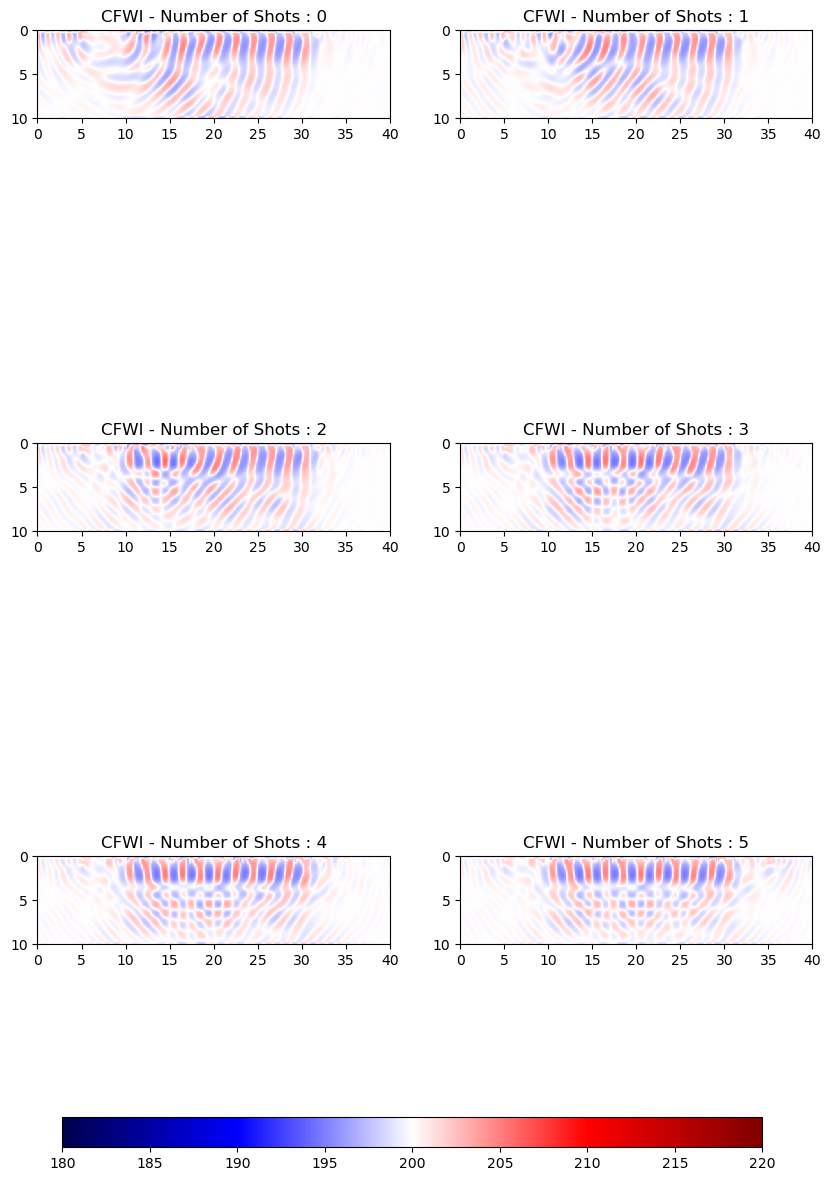

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
fig.subplots_adjust(bottom=0.1)

im = None
for i, ax in enumerate(axes.flat):
    if i < len(vs_c_list):
        data_to_plot = vs_c_list[i]

        im = ax.imshow(data_to_plot,
                       cmap='seismic',
                       aspect='equal',
                       extent=[0, nx*dx, nz*dx, 0],
                       vmax=V_MAX,
                       vmin=V_MIN)

        # 제목의 'Number of Shots' 부분이 0부터 시작하도록 수정
        ax.set_title(f"CFWI - Number of Shots : {i}")

    else:
        ax.axis('off')

# --- 컬러바를 위한 전용 축(cax) 생성 및 컬러바 그리기 ---
if im:
    # add_axes로 컬러바가 그려질 위치와 크기를 직접 지정합니다.
    # [left, bottom, width, height] 형식이며, 전체 그림에 대한 비율입니다.
    cax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

# Regularization을 걸어보자
TV regularization

In [22]:
def total_variation(tensor, dx, dz, eps=1e-6):
    """
    tensor: shape [1, nz, nx]
    returns scalar TV loss
    """
    dz_tensor = (tensor[:, 1:, :] - tensor[:, :-1, :]) / dz  # [1, nz-1, nx]
    dx_tensor = (tensor[:, :, 1:] - tensor[:, :, :-1]) / dx  # [1, nz, nx-1]

    dz_pad = F.pad(dz_tensor, (0,0,0,1), mode='replicate')  # pad bottom
    dx_pad = F.pad(dx_tensor, (0,1,0,0), mode='replicate')  # pad right

    tv = torch.sqrt(dx_pad**2 + dz_pad**2 + eps)
    return tv.mean()

In [23]:
def total_variation_L1(tensor):
    """
    Anisotropic TV (L1-norm) 손실을 계산합니다.
    tensor: shape [batch, channels, nz, nx]
    """
    # z방향과 x방향의 그래디언트(차이)
    grad_z = tensor[:, :, 1:, :] - tensor[:, :, :-1, :]
    grad_x = tensor[:, :, :, 1:] - tensor[:, :, :, :-1]
    
    # 각 그래디언트의 절댓값을 모두 더함
    tv_loss = torch.sum(torch.abs(grad_z)) + torch.sum(torch.abs(grad_x))
    
    return tv_loss

In [52]:
n_epoch = 1000
lr = 1e-2

loss_fn = torch.nn.MSELoss()
losses_cr = []
losses_cr_shot = []
vs_cr_list = []
alpha_tv_list = [1e-1,1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10] 

In [53]:
# 2. alpha_tv 리스트를 순회하며 각 값에 대해 독립적인 역산 수행
for alpha_tv in alpha_tv_list:
    print(f"--- Inverting with alpha_tv = {alpha_tv} ---")

    # 매번 모델과 옵티마이저를 새로 정의
    vs_cr = vs_inv.clone()
    vs_cr.requires_grad = True

    optimizer_cr = torch.optim.Adam([vs_cr], lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_cr, 'min', factor=0.5, patience=5,
    )

    current_run_losses = []

    for epoch in tqdm(range(n_epoch)):
        optimizer_cr.zero_grad()

        # Forward 모델링 (모든 shot 사용)
        syn = deepwave.elastic(
            *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_cr, rho_f),
            grid_spacing=dx, dt=dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=shot,
            receiver_locations_y=receiver_locations,
            pml_freq=f0, pml_width=[0, 10, 10, 10]
        )[-2]
        
        syn = normalized_shot_gather(syn)

        # 3. 데이터 손실과 TV 정규화 손실을 "더해서" 최종 손실을 계산 (오류 수정)
        loss_data = loss_fn(syn, obs)
        tv_reg = alpha_tv * total_variation(vs_cr.unsqueeze(0), dx, dx)
        total_loss = loss_data + tv_reg

        current_run_losses.append(total_loss.item())

        total_loss.backward()
        optimizer_cr.step()
        scheduler.step(total_loss.item())

    # 4. 역산이 끝난 모델을 저장 (오타 수정)
    vs_cr_list.append(vs_cr.detach().cpu().numpy())
    losses_cr_shot.append(current_run_losses)

--- Inverting with alpha_tv = 0.1 ---


100%|██████████| 1000/1000 [02:44<00:00,  6.09it/s]


--- Inverting with alpha_tv = 0.01 ---


100%|██████████| 1000/1000 [02:43<00:00,  6.11it/s]


--- Inverting with alpha_tv = 0.001 ---


100%|██████████| 1000/1000 [02:45<00:00,  6.03it/s]


--- Inverting with alpha_tv = 0.0001 ---


100%|██████████| 1000/1000 [02:44<00:00,  6.08it/s]


--- Inverting with alpha_tv = 1e-05 ---


100%|██████████| 1000/1000 [02:49<00:00,  5.90it/s]


--- Inverting with alpha_tv = 1e-06 ---


100%|██████████| 1000/1000 [02:46<00:00,  6.02it/s]


--- Inverting with alpha_tv = 1e-07 ---


100%|██████████| 1000/1000 [02:50<00:00,  5.85it/s]


--- Inverting with alpha_tv = 1e-08 ---


100%|██████████| 1000/1000 [02:47<00:00,  5.95it/s]


--- Inverting with alpha_tv = 1e-09 ---


100%|██████████| 1000/1000 [02:48<00:00,  5.95it/s]


--- Inverting with alpha_tv = 1e-10 ---


100%|██████████| 1000/1000 [02:47<00:00,  5.97it/s]


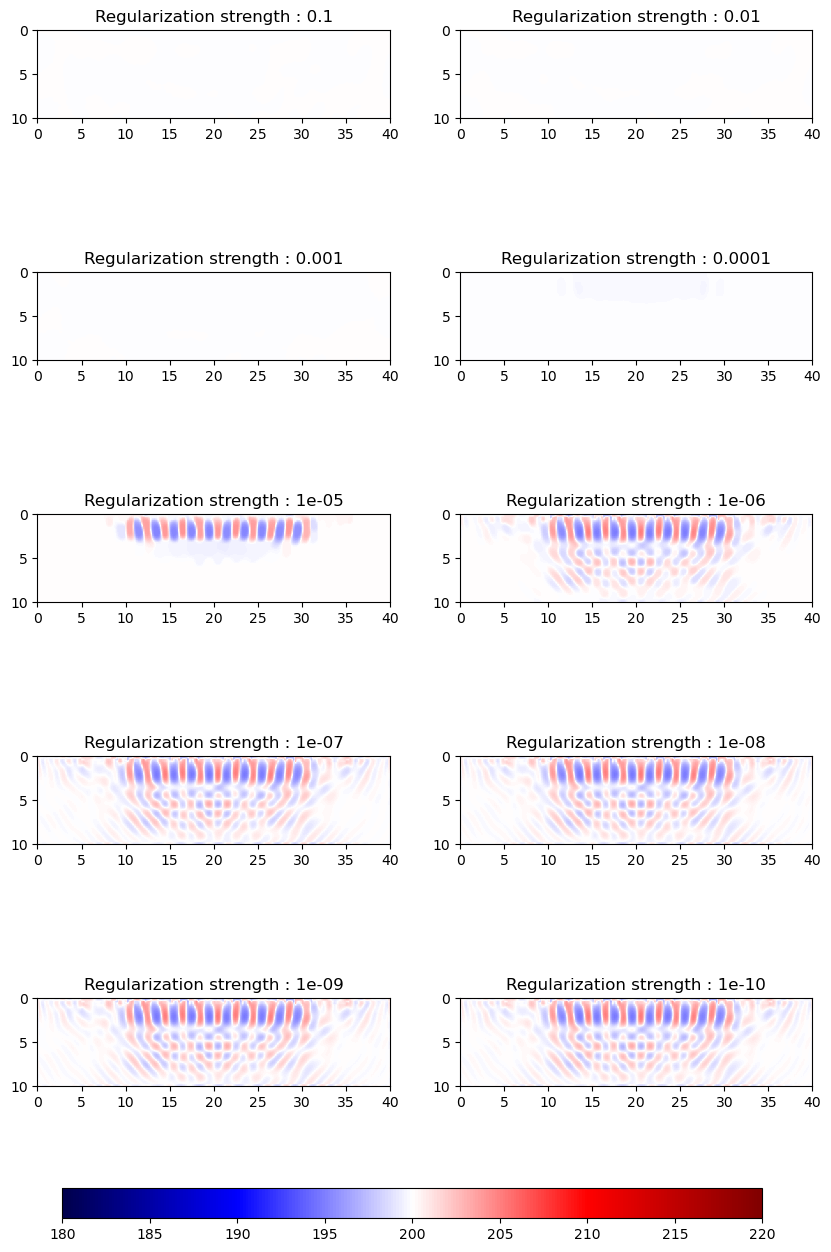

In [54]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
fig.subplots_adjust(bottom=0.1)

im = None
for i, ax in enumerate(axes.flat):
    if i < len(vs_cr_list):
        data_to_plot = vs_cr_list[i]

        im = ax.imshow(data_to_plot,
                       cmap='seismic',
                       aspect='equal',
                       extent=[0, nx*dx, nz*dx, 0],
                       vmax=V_MAX,
                       vmin=V_MIN)

        # 제목의 'Number of Shots' 부분이 0부터 시작하도록 수정
        ax.set_title(f"Regularization strength : {alpha_tv_list[i]}")

    else:
        ax.axis('off')

# --- 컬러바를 위한 전용 축(cax) 생성 및 컬러바 그리기 ---
if im:
    # add_axes로 컬러바가 그려질 위치와 크기를 직접 지정합니다.
    # [left, bottom, width, height] 형식이며, 전체 그림에 대한 비율입니다.
    cax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

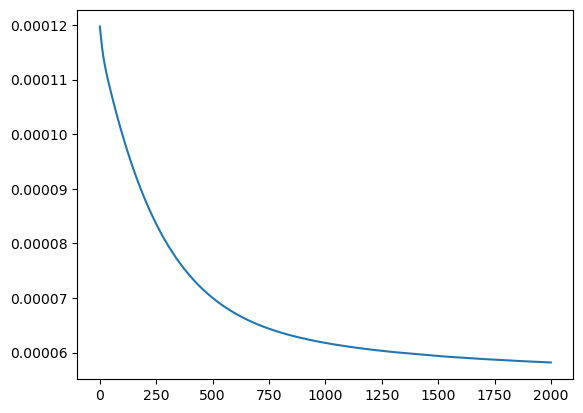

In [26]:
plt.figure()
plt.plot(losses_c6)
plt.show()

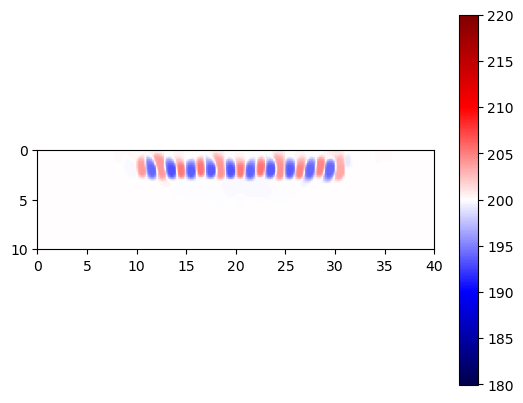

In [27]:
plt.figure()
plt.imshow(vs_c_6.detach().cpu().numpy(), cmap='seismic', aspect='equal', extent=[0, nx * dx, nz * dx, 0], vmax=V_MAX,
           vmin=V_MIN)
plt.colorbar()
plt.show()

# MFWI

In [28]:
vs_m = vs_inv.clone()

In [29]:
f = [20, 40, 60, 80, 100]
n_epoches = [500, 1000, 1500, 2000, 2500]
lr = 1e-2

loss_fn_m = torch.nn.MSELoss()
losses_m = []
losses_m_shot = []

In [30]:
vs_list=[]

In [31]:
for i in range(0,6):
    vs_m = vs_inv.clone()
    vs_m.requires_grad = True
    
    optimizer_m = torch.optim.Adam([vs_m], lr=lr)
    scheduler_m = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_m,
        mode='min',
        factor=0.5,
        patience=5,
        )
    
    obs_i = obs[0:i+1, :, :]
    
    for f0, n_epoch in zip(f, n_epoches):
        obs_low = low_cut(obs_i, f0, dt, device)
        
        for epoch in range(n_epoch):
            optimizer_m.zero_grad()
            
            syn = deepwave.elastic(
                *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_m, rho_f),
                grid_spacing=dx, dt=dt,
                source_amplitudes_y=source_amplitudes,
                source_locations_y=shot,
                receiver_locations_y=receiver_locations,
                pml_freq=f0, pml_width=[0, 10, 10, 10]
                )[-2] [0:i+1, :, :]
            syn = normalized_shot_gather(syn)
            syn_low = low_cut(syn, f0, dt, device)
            loss = loss_fn_m(syn_low, obs_low)
            losses_m.append(loss.item())
            loss.backward()
            optimizer_m.step()
            scheduler_m.step(loss.item())
            
    vs_list.append(vs_m.detach().cpu().numpy())
    losses_m_shot.append(losses_m_shot)

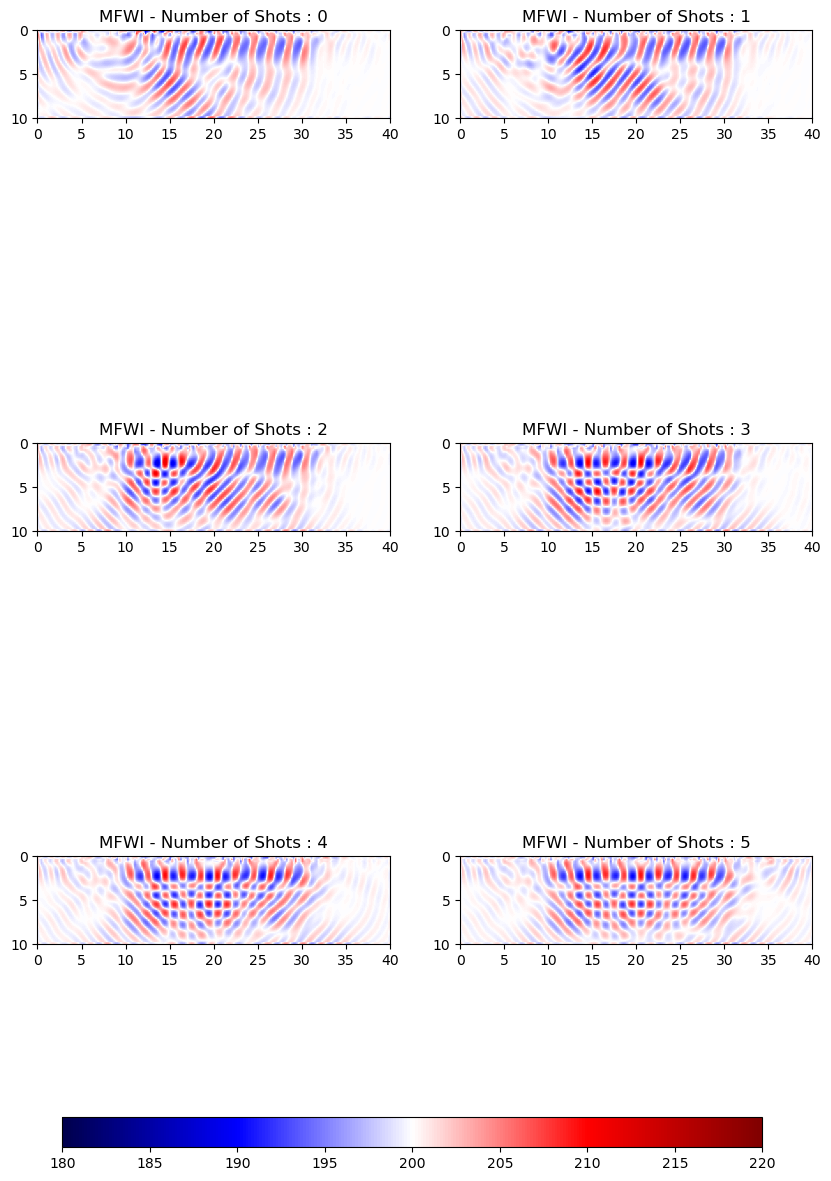

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
fig.subplots_adjust(bottom=0.1)

im = None
for i, ax in enumerate(axes.flat):
    if i < len(vs_list):
        data_to_plot = vs_list[i]

        im = ax.imshow(data_to_plot,
                       cmap='seismic',
                       aspect='equal',
                       extent=[0, nx*dx, nz*dx, 0],
                       vmax=V_MAX,
                       vmin=V_MIN)

        # 제목의 'Number of Shots' 부분이 0부터 시작하도록 수정
        ax.set_title(f"MFWI - Number of Shots : {i}")

    else:
        ax.axis('off')

# --- 컬러바를 위한 전용 축(cax) 생성 및 컬러바 그리기 ---
if im:
    # add_axes로 컬러바가 그려질 위치와 크기를 직접 지정합니다.
    # [left, bottom, width, height] 형식이며, 전체 그림에 대한 비율입니다.
    cax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

EFWI

In [39]:
import torch.nn as nn
class EnvelopeLoss(nn.Module):
    """
    관측 파형과 모델링 파형의 Envelope 차이를 계산하는 PyTorch Loss 클래스입니다.
    E(t) = (u(t)^2 + H[u(t)]^2)^(p/2)
    Loss = MSE(E_obs, E_syn)
    """
    def __init__(self, p: float = 1.0):
        """
        Args:
            p (float): Envelope 계산 시 적용할 지수 (기본값: 1.0)
        """
        super().__init__()
        if p <= 0:
            raise ValueError("지수 'p'는 양수여야 합니다.")
        self.p = p
        self.mse_loss = nn.MSELoss()

    def _calculate_envelope(self, signal: torch.Tensor) -> torch.Tensor:
        """Helper-function to compute the envelope of a signal tensor."""
        if signal.dim() != 3:
            raise ValueError("입력 신호는 3차원 텐서(n_shot, n_rec, n_t)여야 합니다.")

        n = signal.size(-1)
        # Hilbert transform via FFT
        fft = torch.fft.fft(signal, n=n, dim=-1)

        h = torch.zeros(n, device=signal.device, dtype=signal.dtype)
        h[0] = 1
        # Create frequency-domain filter for Hilbert transform
        if n % 2 == 0:
            h[1:n // 2] = 2
            h[n // 2] = 1
        else:
            h[1:(n + 1) // 2] = 2
        
        fft = fft * h.view(1, 1, -1) # Apply filter via broadcasting
        analytic_signal = torch.fft.ifft(fft, n=n, dim=-1)

        # Envelope is the magnitude of the analytic signal
        envelope = torch.sqrt(signal**2 + analytic_signal.imag**2)
        
        return envelope**self.p

    def forward(self, syn: torch.Tensor, obs: torch.Tensor) -> torch.Tensor:
        """
        모델링 파형(syn)과 관측 파형(obs)의 envelope loss를 계산합니다.
        """
        env_syn = self._calculate_envelope(syn)
        env_obs = self._calculate_envelope(obs)
        
        return self.mse_loss(env_syn, env_obs)

In [48]:
n_epoch = 1000
lr = 1e-2

loss_fn_e = EnvelopeLoss()
losses_e = []
losses_e_shot = []
vs_e_list = []

In [49]:
# 6개의 shot에 대해 각각 독립적인 역산을 수행
for i in range(6):
    try:
        print(f"--- Inverting for Shot {i+1}/6 ---")
        
        # 1. 매 shot마다 모델과 옵티마이저, 스케줄러를 "새로" 정의합니다.
        vs_e = vs_inv.clone()
        vs_e.requires_grad = True
        
        optimizer_e = torch.optim.Adam([vs_e], lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer_e,
            mode='min',
            factor=0.5,
            patience=5,
        )
        
        # 현재 shot에 해당하는 관측 데이터 선택
        obs_i = obs[0:i+1, :, :]
        
        # 현재 shot의 epoch별 손실을 저장할 리스트
        current_shot_losses = []

        for epoch in tqdm(range(n_epoch), desc=f"Shot {i+1}"):
            torch.cuda.empty_cache()
            optimizer_e.zero_grad()
            
            syn = deepwave.elastic(
                *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_e, rho_f),
                grid_spacing=dx, dt=dt,
                source_amplitudes_y=source_amplitudes,
                source_locations_y=shot,
                receiver_locations_y=receiver_locations,
                pml_freq=f0, pml_width=[0, 10, 10, 10]
            )[-2][0:i+1, :, :]
            syn = normalized_shot_gather(syn)
            
            loss = loss_fn_e(syn, obs_i)

            # loss가 NaN인 경우, 에러를 발생시켜 except 블록으로 넘어감
            if torch.isnan(loss):
                raise ValueError("Loss is NaN")
            
            current_shot_losses.append(loss.item())
            
            loss.backward()
            
            optimizer_e.step()

            scheduler.step(loss.item())
            
        # 2. 역산이 성공적으로 끝나면, 최종 업데이트된 모델을 저장합니다.
        vs_e_list.append(vs_e.detach().cpu().numpy())
        losses_e_shot.append(current_shot_losses)
        print(f"--- Shot {i+1}/6 Inversion Successful ---")

    except Exception as e:
        # try 블록에서 어떤 에러든 발생하면 이 코드가 실행됩니다.
        print(f"\n[Error] An error occurred during Shot {i+1}: {e}")
        print(f"--- Skipping to the next shot ---")
        continue # 즉시 다음 i로 넘어갑니다.

--- Inverting for Shot 1/6 ---


Shot 1: 100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


--- Shot 1/6 Inversion Successful ---
--- Inverting for Shot 2/6 ---


Shot 2: 100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]


--- Shot 2/6 Inversion Successful ---
--- Inverting for Shot 3/6 ---


Shot 3: 100%|██████████| 1000/1000 [03:24<00:00,  4.88it/s]


--- Shot 3/6 Inversion Successful ---
--- Inverting for Shot 4/6 ---


Shot 4:  80%|████████  | 804/1000 [02:42<00:39,  4.96it/s]



[Error] An error occurred during Shot 4: cannot convert float NaN to integer
--- Skipping to the next shot ---
--- Inverting for Shot 5/6 ---


Shot 5: 100%|██████████| 1000/1000 [03:28<00:00,  4.79it/s]


--- Shot 5/6 Inversion Successful ---
--- Inverting for Shot 6/6 ---


Shot 6: 100%|██████████| 1000/1000 [03:30<00:00,  4.75it/s]

--- Shot 6/6 Inversion Successful ---


IndexError: list index out of range

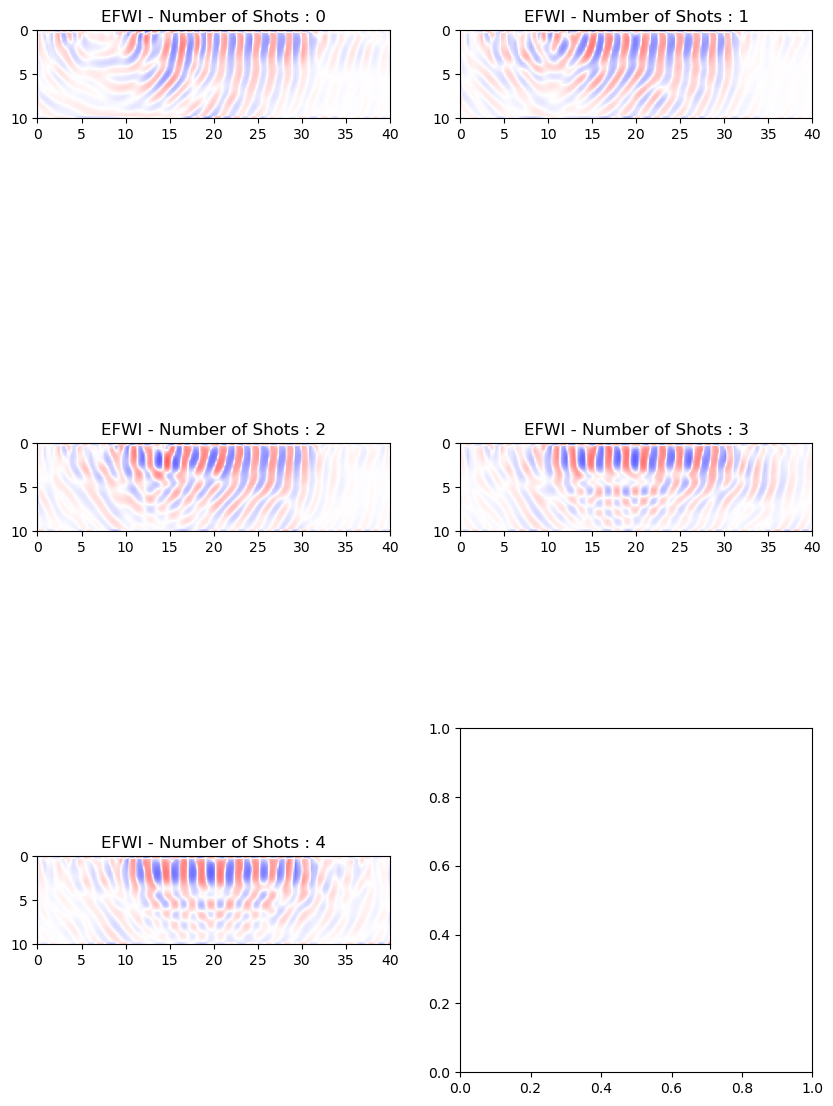

In [50]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))
fig.subplots_adjust(bottom=0.1)

im = None
for i, ax in enumerate(axes.flat):
    if i < len(vs_list):
        data_to_plot = vs_e_list[i]

        im = ax.imshow(data_to_plot,
                       cmap='seismic',
                       aspect='equal',
                       extent=[0, nx*dx, nz*dx, 0],
                       vmax=V_MAX,
                       vmin=V_MIN)

        # 제목의 'Number of Shots' 부분이 0부터 시작하도록 수정
        ax.set_title(f"EFWI - Number of Shots : {i}")

    else:
        ax.axis('off')

# --- 컬러바를 위한 전용 축(cax) 생성 및 컬러바 그리기 ---
if im:
    # add_axes로 컬러바가 그려질 위치와 크기를 직접 지정합니다.
    # [left, bottom, width, height] 형식이며, 전체 그림에 대한 비율입니다.
    cax = fig.add_axes([0.15, 0.05, 0.7, 0.02])
    fig.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

# Soft-DTW

In [57]:
from tslearn.metrics import SoftDTWLossPyTorch
vs_s = vs_inv.clone()
vs_s.requires_grad = True
n_epoch = 1000
lr = 1e-2
vs_s_list = []
losses_s_shot = []

In [58]:
# 6개의 shot에 대해 각각 독립적인 역산을 수행
for i in range(6):
    print(f"--- Inverting for Shot {i+1}/6 ---")
    
    # 1. 매 shot마다 모델과 옵티마이저, 스케줄러를 "새로" 정의합니다.
    vs_s = vs_inv.clone()
    vs_s.requires_grad = True
    
    optimizer_s = torch.optim.Adam([vs_s], lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer_s,
        mode='min',
        factor=0.5,
        patience=5,
    )
    
    # 현재 shot에 해당하는 관측 데이터 선택
    obs_i = obs[0:i+1, :, :]
    
    # 현재 shot의 epoch별 손실을 저장할 리스트
    current_shot_losses = []

    for epoch in tqdm(range(n_epoch)):
        torch.cuda.empty_cache()
        optimizer_s.zero_grad()
        
        # deepwave.elastic은 모든 shot을 한 번에 계산하므로,
        # 결과에서 현재 shot에 해당하는 데이터만 인덱싱합니다.
        syn = deepwave.elastic(
            *deepwave.common.vpvsrho_to_lambmubuoyancy(vp_f, vs_s, rho_f),
            grid_spacing=dx, dt=dt,
            source_amplitudes_y=source_amplitudes,
            source_locations_y=shot, # 모든 shot 위치
            receiver_locations_y=receiver_locations,
            pml_freq=f0, pml_width=[0, 10, 10, 10]
        )[-2][0:i+1, :, :] # 결과에서 i번째 shot 데이터만 선택
        syn = normalized_shot_gather(syn)
        
        loss = loss_fn(syn, obs_i)
        current_shot_losses.append(loss.item())
        
        loss.backward()
        optimizer_s.step()
        scheduler.step(loss.item())
        
    # 2. 한 shot에 대한 역산이 끝나면, 최종 업데이트된 모델을 저장합니다.
    vs_s_list.append(vs_s.detach().cpu().numpy())
    losses_s_shot.append(current_shot_losses)

--- Inverting for Shot 1/6 ---


100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s]


--- Inverting for Shot 2/6 ---


100%|██████████| 1000/1000 [06:02<00:00,  2.76it/s]


--- Inverting for Shot 3/6 ---


100%|██████████| 1000/1000 [06:41<00:00,  2.49it/s]


--- Inverting for Shot 4/6 ---


100%|██████████| 1000/1000 [06:52<00:00,  2.43it/s]


--- Inverting for Shot 5/6 ---


100%|██████████| 1000/1000 [06:49<00:00,  2.44it/s]


--- Inverting for Shot 6/6 ---


100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]
